## Toxic Releases By Mitchell Caplan

Lets get started by loading in the data for neighborhoods

In [1]:
import geopandas as gpd
import pandas as pd
import fpsnippets
import matplotlib.pyplot as plt

pitt = gpd.read_file('Neighbor/Neighborhoods_.shp')

pitt.head(3)

,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
0,1,233,42,003,140500,3,420031405003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,7968760.0,a642a6b6-a2a9-48d5-acf2-3e2ce87d4bc0,8.153647e+06,14047.065024,"POLYGON ((-79.90560 40.45522, -79.90553 40.455..."
1,2,203,42,003,140100,3,420031401003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,34078712.0,20d4605b-258e-441a-a57e-a28fdabb6d30,3.407739e+07,30347.886823,"POLYGON ((-79.91309 40.43804, -79.91321 40.438..."
2,3,86,42,003,101700,2,420031017002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,12751163.0,bf4065e7-c29c-48bd-b529-e7fd99077238,1.275116e+07,14577.441571,"POLYGON ((-79.93457 40.47217, -79.93455 40.472..."


Lets also load in the dataset that will be needed for them to be processed into graphs and also filter out the one their was still clean air

In [2]:
toxic = pd.read_csv('TRIair.csv')
toxic_no = toxic[toxic['CLEAN_AIR'] == 'N']

toxic_no.head(10)

,_id,TRI_FACILITY_ID,DOC_CTRL_NUM,FACILITY_NAME,STREET_ADDRESS,CITY_NAME,COUNTY_NAME,STATE_COUNTY_FIPS_CODE,STATE_ABBR,ZIP_CODE,...,NAICS_CODES,INDUSTRY_CODE,SRS_ID,PFAS_IND,ENVIRONMENTAL_MEDIUM,RELEASE_RANGE_CODE,TOTAL_RELEASE,REL_EST_AMT,RELEASE_NA,RELEASE_BASIS_EST_CODE
7,522794,15225SHLND2650N,1397110000799,INEOS COMPOSITES US LLC,2650 NEVILLE RD,PITTSBURGH,ALLEGHENY,42003,PA,15225,...,325211.0,325,6643.0,N,AIR FUG,NaN,160.0,160.0,0,O
8,522795,15225SHLND2650N,1397110000799,INEOS COMPOSITES US LLC,2650 NEVILLE RD,PITTSBURGH,ALLEGHENY,42003,PA,15225,...,325211.0,325,6643.0,N,AIR STACK,NaN,310.0,310.0,0,O
21,522808,15201PRSSR3419S,1397110001169,PRESSURE CHEMICAL CO,3419 SMALLMAN ST,PITTSBURGH,ALLEGHENY,42003,PA,15201,...,325199.0,325,27003.0,N,AIR FUG,NaN,0.0,0.0,1,NaN
22,522809,15201PRSSR3419S,1397110001169,PRESSURE CHEMICAL CO,3419 SMALLMAN ST,PITTSBURGH,ALLEGHENY,42003,PA,15201,...,325199.0,325,27003.0,N,AIR STACK,NaN,7524.0,7524.0,0,C
41,522828,15051MRCNRSTATE,1397110023227,KINDER MORGAN TRANSMIX CO LLC,918 RT 910,INDIANOLA,ALLEGHENY,42003,PA,15051,...,324110.0,324,16261.0,N,AIR FUG,NaN,165.0,165.0,0,O
42,522829,15051MRCNRSTATE,1397110023227,KINDER MORGAN TRANSMIX CO LLC,918 RT 910,INDIANOLA,ALLEGHENY,42003,PA,15051,...,324110.0,324,16261.0,N,AIR STACK,NaN,45.0,45.0,0,O
45,522832,15226MTTHW1315W,1397110036946,MATTHEWS INTERNATIONAL CORP,1315 W LIBERTY AVE,PITTSBURGH,ALLEGHENY,42003,PA,15226,...,331525.0,331,152363.0,N,AIR FUG,3.0,250.0,250.0,0,E
46,522833,15226MTTHW1315W,1397110036946,MATTHEWS INTERNATIONAL CORP,1315 W LIBERTY AVE,PITTSBURGH,ALLEGHENY,42003,PA,15226,...,331525.0,331,152363.0,N,AIR STACK,3.0,250.0,250.0,0,E
47,522834,15202PTTSB1HERR,1397110038914,PITTSBURGH INDL PLATING,1 HERRON AVE,PITTSBURGH,ALLEGHENY,42003,PA,15202,...,332813.0,332,152686.0,N,AIR FUG,1.0,5.0,5.0,0,O
48,522835,15202PTTSB1HERR,1397110038914,PITTSBURGH INDL PLATING,1 HERRON AVE,PITTSBURGH,ALLEGHENY,42003,PA,15202,...,332813.0,332,152686.0,N,AIR STACK,NaN,0.0,0.0,0,O


Add the releases to the approiate values into the dataframe

In [17]:
add_val = {"Neighborhood" : [],
          "Release" : []}
rows = 0
for i, tox in toxic_no.iterrows():
    
    possible = fpsnippets.zip_to_neighborhoods(tox['ZIP_CODE'])
    amount = tox["TOTAL_RELEASE"]
    
    if possible:
        for thing in possible:
            add_val["Neighborhood"].append(thing)
            add_val['Release'].append(amount)
            rows += 1
            
neighborhoods = pd.DataFrame(add_val,index = list(range(rows)))
neighborhoods.to_csv("revised_data.csv", index=False)

Basic setup and summing the data together

In [18]:
data = pd.read_csv('revised_data.csv')
summed_values = data.groupby('Neighborhood')['Release'].sum().reset_index()

revised_neighborhoods = pd.DataFrame(summed_values)

revised_neighborhoods.head(10)

,Neighborhood,Release
0,Allegheny Center,303411.00
1,Allegheny West,303411.00
2,Allentown,1800.00
3,Arlington,1800.00
4,Arlington Heights,1800.00
5,Banksville,77000.00
6,Bedford Dwellings,820.00
7,Beechview,277611.00
8,Beltzhoover,200611.00
9,Bloomfield,1066991.14


Get the biggest toxic releases in the top 10 neighbors 

In [19]:
neighborhoods_sorted = revised_neighborhoods.sort_values("Release", ascending=False)

neighborhoods_sorted.head(10)

,Neighborhood,Release
36,Hays,2543151.61
43,Lincoln Place,2542784.61
51,New Homestead,1438432.00
73,Squirrel Hill South,1405037.22
66,South Oakland,1400012.00
37,Hazelwood,1399192.00
35,Greenfield,1399192.00
34,Glen Hazel,1399192.00
27,East Liberty,1066991.14
33,Garfield,1066991.14


We see that Hayes is the neighborhood with the most Toxic Releases. Let's plot the top 10 neighborhoods.(Measured by Million)

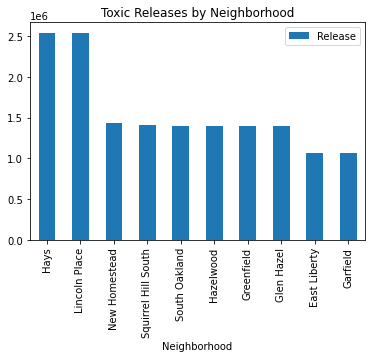

In [20]:
plt = neighborhoods_sorted.iloc[:10].plot(kind='bar', x="Neighborhood", y="Release", title="Toxic Releases by Neighborhood")

Let plot the bottom 10. (measured in hundreds)

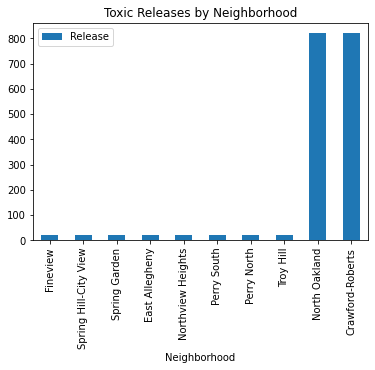

In [21]:
neighborhoods_asc = neighborhoods_sorted.sort_values("Release")
plt2 = neighborhoods_asc.iloc[:10].plot(kind='bar', x="Neighborhood", y="Release", title="Toxic Releases by Neighborhood")

Lets add the data to the map of pittsburgh

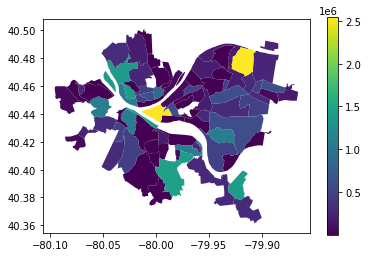

In [22]:
pitt["TOTAL_RELEASE"] = revised_neighborhoods["Release"]

pitt.plot(column="TOTAL_RELEASE", legend=True)

That the conclusion of a map of pittsburgh that has the most Toxic Releases